# 1. Load dataset

![Text Classification using Transformer Encoder](assets/images/text_cls_using_transformer_encoder.png)

In [1]:
from datasets import load_dataset

dataset = load_dataset("thainq107/ntc-scv")

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

In [2]:
dataset['train'][:10]

{'sentence': ['Cửa_hàng nhỏ xinh trên mặt_đường , vị_trí khá dễ tìm . Đồ_ăn ngon , giá phải_chăng , 2 bánh mỳ chảo cười , 1 bánh mỳ sốt vang và 3 xúc_xích cùng sữa ngô nữa , hết có 150 k . Qúa ổn luôn ! ! !\n',
  'Mình mới check in quán này hôm_nay . Quán năm bên trong ngõ một_chút , nếu_không để_ý là dễ_dàng bỏ_qua mất . Không_gian yên_tĩnh , nhạc nhẹ_nhàng du_dương . Thích_hợp cho những bạn muốn tìm nơi thư_giãn trong giờ nghỉ trưa ( mình chưa tới buổi tối nên không nói buổi tối nha ) . Đồ_ăn và nước uống ngon hợp với khẩu_vị của mình , giá_cả so với chất_lượng thì ok . Mải_mê với đồ_ăn nên mình chỉ chụp mỗi hình đồ_ăn thôi . Hihi\n',
  'Quán không khó tìm như mình nghĩ . Bước chân vào quán như bước chân vào ngôi nhà của nước Pháp , từ những vât dụng trang_trí , bàn_ghế đến những bản_nhạc Pháp trữ_tình . Món ăn hợp_khẩu vị ( crepe mặn hải_sản , salad với sauce chua_chua ngọt ngọt kích_thích vị_giác , món thịt gà ko bị khô thịt , và món crepe ngọt ) , trang_trí đẹp_mắt , menu tthức uố

# 2. Preprocessing

In [3]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www
    url_pattern = re.compile(r'https?://\\s+\\wwww\\.\\s+')
    text = url_pattern.sub(r" ", text)
    
    # remove HTML tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)
    
    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, ' ')
    
    # remove emoji
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"  # emoticons again
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # enclosed characters
        u"\U0001f926-\U0001f937"  # more emoticons
        u"\U0001F1F2"            # single characters
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"               # zero width joiner
        u"\u2640-\u2642"       # gender symbols
        "]+", 
        flags=re.UNICODE
    )

    text = emoji_pattern.sub(r" ", text)
    
    # normalize whitespace
    text = ' '.join(text.split())
    
    text = text.lower()
    return text



# 3. Representation

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')

def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

def build_vocab(sentences, max_tokens=10000):
    vocab = {
        '<pad>': 0,
        '<unk>': 1,
    }
    word_freq = Counter()
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        word_freq.update(tokens)
        
    most_common_tokens = word_freq.most_common(max_tokens - len(vocab))
    for token, _ in most_common_tokens:
        vocab[token] = len(vocab)
        
    return vocab

vocab = build_vocab(dataset['train']['preprocessed_sentence'], max_tokens=10000)

def prepare_dataset(dataset, vocab):
    for row in dataset:
        sentence = row['preprocessed_sentence']
        tokens = word_tokenize(sentence)
        encoded_sentence = [vocab.get(token, vocab['<unk>']) for token in tokens]
        label = row['label']
        yield encoded_sentence, label

train_dataset = list(prepare_dataset(dataset['train'], vocab))
valid_dataset = list(prepare_dataset(dataset['valid'], vocab))
test_dataset = list(prepare_dataset(dataset['test'], vocab))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 4. Dataloader

In [5]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs , offsets , labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]
    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)
    
    return encoded_sentences, labels

from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


# 5. Trainer

In [6]:
import os
import time

def train_epoch(model, optimizer, criterion, train_loader, device, epoch=0, log_interval=50):
    model.train()
    total_acc = total_cnt = 0
    losses = []
    start_time = time.time()
    
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs)
        
        loss = criterion(predictions, labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(dim=1) == labels).sum().item()
        total_cnt += labels.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} | {idx}/{len(train_loader)} batches | "
                  f"loss={loss.item():.4f} | acc={total_acc/total_cnt:.4f} | "
                  f"{elapsed}s/batch")
            start_time = time.time()
            total_acc = total_cnt = 0
            start_time = time.time()
            
    epoch_acc = total_acc / total_cnt
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

def evaluate_epoch(model, criterion, valid_loader, device):
    model.eval()
    total_acc = total_cnt = 0
    losses = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            
            total_acc += (predictions.argmax(dim=1) == labels).sum().item()
            total_cnt += labels.size(0)
    
    epoch_acc = total_acc / total_cnt
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def train(model, model_name, save_model, optimizer, criterion, train_loader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = float('inf')
    times = []
    
    save_path = os.path.join(save_model, f"{model_name}_best.pth")
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_loader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)
        
        if eval_loss < best_loss_eval:
            best_loss_eval = eval_loss
            torch.save(model.state_dict(), save_path)
        
        elapsed = time.time() - start_time
        times.append(elapsed)
        
        print('-' * 100)
        print(f"Epoch {epoch} | Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | "
              f"Eval Acc: {eval_acc:.4f} | Eval Loss: {eval_loss:.4f} | "
              f"{elapsed}s")
        print('-' * 100)
        
    model.load_state_dict(torch.load(save_path))
    model.eval()
    metrics = {
        'train_accs': train_accs,
        'train_losses': train_losses,
        'eval_accs': eval_accs,
        'eval_losses': eval_losses,
        'times': times
    }
    return model, metrics

In [11]:
import matplotlib.pyplot as plt


def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(1, num_epochs + 1))  # Start from 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot accuracy
    axs[0].plot(epochs, train_accs, label='Train Acc')
    axs[0].plot(epochs, eval_accs, label='Eval Acc')
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot loss
    axs[1].plot(epochs, train_losses, label='Train Loss')
    axs[1].plot(epochs, eval_losses, label='Eval Loss')
    axs[1].set_title('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# 6. Modeling

In [8]:
from torch import nn


class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)
        return out2

class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(src_vocab_size, embed_dim, max_length, device)
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.encoder_blocks:
            x = layer(x, x, x)
        return x

class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_size, num_heads, num_layers, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(
            src_vocab_size = vocab_size,
            embed_dim = embed_size,
            max_length = max_length,
            num_layers = num_layers,
            num_heads = num_heads,
            ff_dim = ff_dim,
            dropout = dropout,
            device = device
        )
        self.pooling = nn.AvgPool1d(kernel_size = max_length)
        self.fc1 = nn.Linear(in_features = embed_size, out_features = 20)
        self.fc2 = nn.Linear(in_features = 20, out_features = 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.pooling(x.permute(0, 2, 1))
        x = x.squeeze(2)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        
    

In [9]:
import os
import torch.optim as optim

vocab_size = len(vocab)
max_length = 100
embed_size = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TransformerEncoderCls(
    vocab_size = vocab_size,
    max_length = max_length,
    embed_size = embed_size,
    num_heads = num_heads,
    num_layers = num_layers,
    ff_dim = ff_dim,
    dropout = dropout,
    device = device
)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 5
save_model = './models'
os.makedirs(save_model, exist_ok=True)
model_name = 'transformer_encoder_cls'

model, metrics = train(model, model_name, save_model, optimizer, criterion, train_loader, valid_loader, num_epochs, device)

Epoch 1 | 50/235 batches | loss=0.6854 | acc=0.5221 | 126.94222831726074s/batch
Epoch 1 | 100/235 batches | loss=0.6807 | acc=0.5670 | 75.92029166221619s/batch
Epoch 1 | 150/235 batches | loss=0.6551 | acc=0.6381 | 87.80870151519775s/batch
Epoch 1 | 200/235 batches | loss=0.6196 | acc=0.6784 | 90.24936294555664s/batch
----------------------------------------------------------------------------------------------------
Epoch 1 | Train Acc: 0.7399 | Train Loss: 0.6540 | Eval Acc: 0.7585 | Eval Loss: 0.5286 | 486.13837695121765s
----------------------------------------------------------------------------------------------------
Epoch 2 | 50/235 batches | loss=0.4596 | acc=0.7734 | 86.98110961914062s/batch
Epoch 2 | 100/235 batches | loss=0.5111 | acc=0.7864 | 80.35148811340332s/batch
Epoch 2 | 150/235 batches | loss=0.4651 | acc=0.7905 | 74.76203489303589s/batch
Epoch 2 | 200/235 batches | loss=0.4341 | acc=0.7891 | 83.29857468605042s/batch
-------------------------------------------------

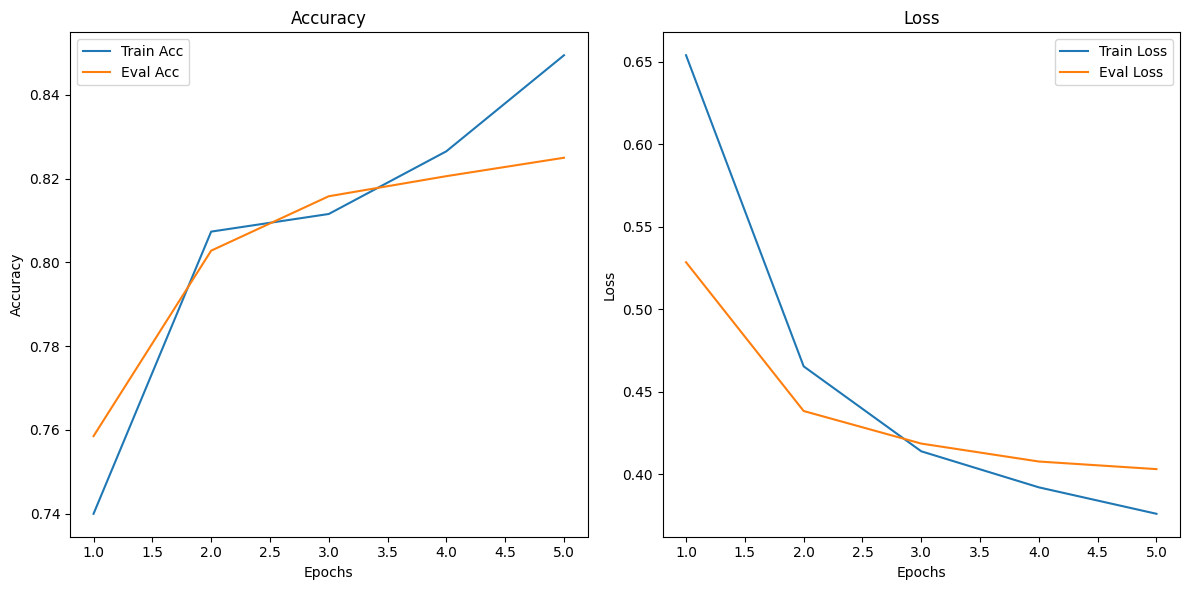

In [12]:
plot_result(num_epochs, metrics['train_accs'], metrics['eval_accs'], metrics['train_losses'], metrics['eval_losses'])
